# Conformal prediction for classification

In [83]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

Conformal prediction ({cite:t}`vovk_al,shaf_at08,bala_cp`) is a framework for reliable prediction that is rooted in classical frequentist statistics, more specifically in hypothesis testing[^revision].
Given a sequence of training observations and a new query $\vec{x}_{N+1}$ (which we denoted by $\vec{x}_{q}$ before and in the following plot is marked red) with unknown outcome $y_{N+1}$,

$$
(\vec{x}_1, y_1), \,  (\vec{x}_2, y_2), \ldots ,  (\vec{x}_N, y_N), \, (\vec{x}_{N+1}, \bullet)
\enspace ,
$$(cpseq)

[^revision]: If this concept is new to you we recommend visiting our site on Hypothesis Testing {doc}`hypothesis-excurs`.

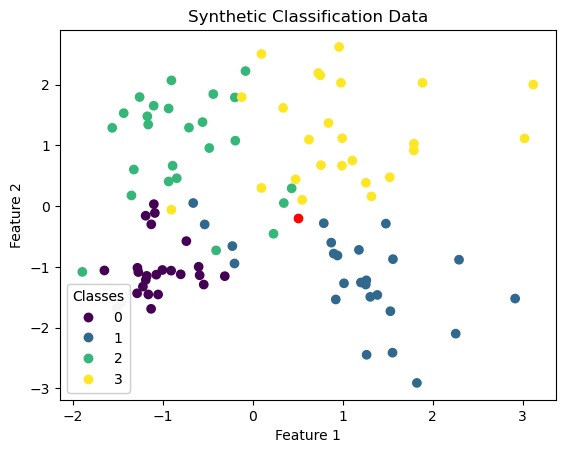

In [84]:
n_samples = 100
n_classes = 4

epsilon = 0.05 # This choice is the central point of conformel prediction


X, y = make_classification(
    n_samples=n_samples,
    n_classes=n_classes,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=31,
)
x_new = np.array([0.5, -0.2])

fig, ax = plt.subplots()

ax.set_title("Synthetic Classification Data")

scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.scatter(*x_new, c="r")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

the basic idea is to hypothetically replace $\bullet$ by each candidate, i.e., to test the hypothesis $y_{N+1} = y$ for all $y \in \mathcal{Y}$. Only those outcomes $y$ for which this hypothesis can be rejected at a predefined level of confidence are excluded, while those for which the hypothesis cannot be rejected are collected to form the prediction set or *prediction region* $Y^\epsilon \subseteq \mathcal{Y}$. The construction of a set-valued prediction $Y^\epsilon = Y^\epsilon(\vec{x}_{n+1})$ that is guaranteed to cover the true outcome $y_{N+1}$ with a given probability $1- \epsilon$ (for example 95\,\%), instead of producing a point prediction $\hat{y}_{N+1} \in \mathcal{Y}$, is the basic idea of conformal prediction. Here, $\epsilon \in (0,1)$ is a pre-specified level of significance. In the case of classification, $Y^\epsilon$ is a subset of the set of classes $\mathcal{Y} = \{ y_1, \ldots , y_K \}$, whereas in regression, a prediction region is commonly represented in terms of an interval[^regressionCase].

[^regressionCase]: Obviously, since $\mathcal{Y} = \mathbb{R}$ is infinite in regression, a hypothesis test cannot be conducted explicitly for each candidate outcome $y$. 

Hypothesis testing is done in a nonparametric way: Consider any ''nonconformity'' function $f: \, \mathcal{X} \times \mathcal{Y} \longrightarrow \mathbb{R}$ that assigns scores $\alpha = f(\vec{x}, y)$ to input/output tuples; the latter can be interpreted as a measure of ''strangeness'' of the pattern $(\vec{x}, y)$, i.e., the higher the score, the less the data point $(\vec{x}, y)$ conforms to what one would expect to observe.

An example of a nonconformity score based on $k$ nearest neighbors:

$$
f(\vec{x},y) = \frac{\sum_{i=1}^k d_i^+}{\sum_{i=1}^k d_i^-}
$$

where $d_i^+$ is the distance from the $i^{th}$ nearest neighbor labeled y, and $d_i^-$ the distance from the $i^{th}$ nearest neighbor labeled differently.

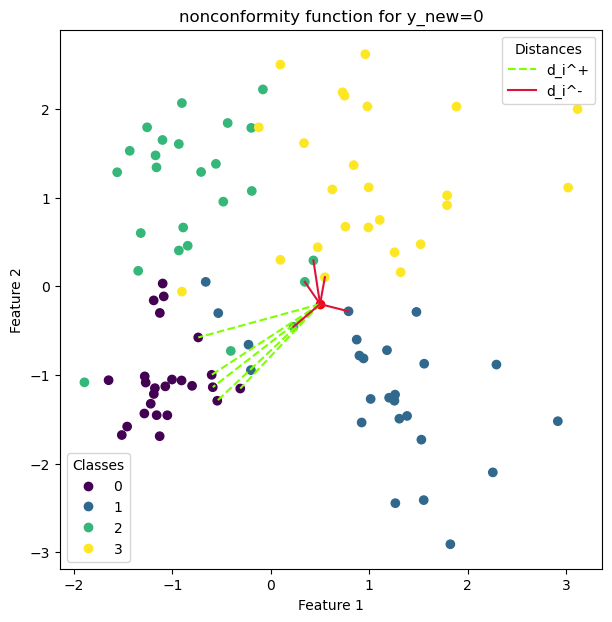

In [85]:
def euclidean_distance(x, data):
    dist = np.linalg.norm(
        x - data, axis=1, ord=2
    )  # L2-norm (euclidean distance between x and all data points in X)
    return dist


def nearest_neighbors_idx(distances, k=5):
    idx = np.argpartition(
        distances, k
    )  # makes the kth element as pivot such that left from it are all smaller elements
    return idx[:k]


def nearest_neighbors_distance(x, data, k=5):
    dist = euclidean_distance(x, data)
    idx = nearest_neighbors_idx(dist, k)
    return dist[idx]  # get the distances of the k nearest neighbors


def split_data_classes(y_i, X, y):
    # create two datasets one where each point has the same class as y_i the other points in the second dataset.
    mask_same_class = y == y_i
    data_with_same_class = X[mask_same_class, :]
    data_with_other_class = X[~mask_same_class, :]
    return data_with_same_class, data_with_other_class


def nonconformity_function(x_i, y_i, X, y):
    data_with_same_class, data_with_other_class = split_data_classes(y_i, X, y)
    distance_to_same_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_same_class, k=5)
    )
    distance_to_other_class = np.sum(
        nearest_neighbors_distance(x_i, data_with_other_class, k=5)
    )

    return distance_to_same_class / distance_to_other_class


def plot_nearest_neighbors_distance(y_new, ax):
    ax.set_title(f"nonconformity function for y_new={y_new}")

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.scatter(*x_new, c="red")

    # visualize the distance to the equally labeled points:
    data_with_same_class, data_with_other_class = split_data_classes(y_new, X, y)
    for i in nearest_neighbors_idx(
        euclidean_distance(x_new, data_with_same_class), k=5
    ):
        x_values = [x_new[0], data_with_same_class[i, 0]]
        y_values = [x_new[1], data_with_same_class[i, 1]]
        (line1,) = ax.plot(
            x_values, y_values, linestyle="--", c="chartreuse", label="d_i^+"
        )

    # visualize the distance to the differently labeled points:
    for i in nearest_neighbors_idx(
        euclidean_distance(x_new, data_with_other_class), k=5
    ):
        x_values = [x_new[0], data_with_other_class[i, 0]]
        y_values = [x_new[1], data_with_other_class[i, 1]]
        (line2,) = ax.plot(
            x_values, y_values, linestyle="-", c="crimson", label="d_i^-"
        )

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    # produce a legend with the distance
    ax.legend(handles=[line1, line2], loc="upper right", title="Distances")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
plot_nearest_neighbors_distance(y_new=0, ax=ax)
# plot_nearest_neighbors_distance(y_new=1, ax=ax)
# plot_nearest_neighbors_distance(y_new=2, ax=ax)
# plot_nearest_neighbors_distance(y_new=3, ax=ax)
plt.show()

Applying this function to the sequence {eq}`cpseq`, with a specific (though hypothetical) choice of $y = y_{N+1}$ (let us pick y = 0), yields a sequence of scores

$$
\alpha_1, \, \alpha_2, \ldots , \alpha_N , \, \alpha_{N+1} \enspace .
$$

In [86]:
def get_nonconformityScores(x_new, y_new):
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)  # merge X and y into one array
    new_point = np.hstack((x_new, y_new))  # make the new data point
    complete_data = np.vstack((data, new_point))  # put all together

    resulting_scores = np.array(
        [
            nonconformity_function(
                x_i=complete_data[i, :-1],
                y_i=complete_data[i, -1],
                X=np.delete(complete_data, i, axis=0)[:, :-1],
                y=np.delete(complete_data, i, axis=0)[:, -1],
            )
            for i in range(complete_data.shape[0])
        ]
    )

    return resulting_scores

alpha_values_y0 = get_nonconformityScores(x_new=x_new,y_new=0)
alpha_values_y0

array([0.77314968, 0.68439392, 0.4278431 , 0.3351231 , 0.31205702,
       0.37149363, 0.38839207, 2.34878393, 3.44963777, 1.23632178,
       0.24002514, 1.05460681, 0.82161649, 0.57034633, 1.58489954,
       0.45756937, 0.44887226, 0.67247494, 1.04008292, 0.24198849,
       0.32940179, 0.38664866, 0.27318212, 2.91793606, 0.37580255,
       0.70710082, 0.24400042, 0.32505527, 0.11035944, 0.66771116,
       0.91566299, 0.37693889, 0.16337647, 0.14007474, 0.36650715,
       0.14241597, 0.27620508, 0.20424121, 0.14868598, 2.32878916,
       0.14263151, 0.39294787, 0.2030195 , 0.20843384, 0.15618444,
       0.27426505, 0.54216901, 1.798158  , 0.34479019, 2.60135297,
       0.43759038, 0.34668837, 1.21901677, 0.41059399, 0.41424125,
       1.59304939, 0.37108512, 0.67806662, 0.33722239, 0.20835847,
       0.80379316, 0.37524613, 0.13463129, 5.9159343 , 1.76058581,
       0.13357575, 0.16599407, 0.7740414 , 0.48088605, 1.33502035,
       0.44453412, 0.90293159, 0.4927097 , 0.34081446, 0.17300

Denote by $\sigma$ the permutation of $\{1, \ldots , N+1\}$ that sorts the scores in increasing order, i.e., such that $\alpha_{\sigma(1)} \leq \ldots \leq \alpha_{\sigma(N+1)}$. Under the assumption that the hypothetical choice of $y_{N+1}$ is in agreement with the true data-generating process, and that this process has the property of exchangeability (which is weaker than the assumption of independence and essentially means that the order of observations is irrelevant), every permutation $\sigma$ has the same probability of occurrence. Consequently, the probability that $\alpha_{N+1}$ is among the $\epsilon$\,\% highest nonconformity scores should be low. This notion can be captured by the $p$-values associated with the candidate $y$, defined as 

$$
p(y)   := \frac{\# \{ i \given \alpha_i \geq \alpha_{N+1} \}}{N+1}
$$

In [87]:
def calculate_probability(nonconformity_sequence):
    # calculate the proportion that atleast the new datapoints nonconformity score occurs.
    new_datapoint_nonconformityScore = nonconformity_sequence[-1]
    probability = np.sum(
        nonconformity_sequence >= new_datapoint_nonconformityScore
    ) / len(
        nonconformity_sequence
    )  # the N + 1 is inherently in the length of the sequence
    return probability

probability_y0 = calculate_probability(alpha_values_y0)
probability_y0

0.019801980198019802

According to what we said, the probability that $p(y) < \epsilon$ (i.e., $\alpha_{N+1}$ is among the $\epsilon$\,\% highest $\alpha$-values) is upper-bounded by $\epsilon$. 
Thus, the hypothesis $y_{N+1} = y$ can be rejected for those candidates $y$ for which $p(y) < \epsilon$. 
For the initial choice y = 0 we can reject this candidate, because $p(y) = 0.019 < 0.05 = \epsilon$.
The complete $Y\epsilon$ can then be constructed iterating through all possible candidates $y = y_{N+1}$. 

In [88]:
Y_hat = np.array(
    [
        i
        for i in range(n_classes)
        if calculate_probability(get_nonconformityScores(x_new, i)) >= 0.05
    ]
)
Y_hat

array([1, 2, 3])

<div align="justify">

Conformal prediction as outlined above realizes transductive inference, although inductive variants also exist ({cite:t}`papa_ic08`).  The error bounds are valid and well calibrated by construction, regardless of the nonconformity function $f$. However, the choice of this function has an important influence on the *efficiency* of conformal prediction, that is, the size of prediction regions: The more suitable the nonconformity function is chosen, the smaller these sets will be. 

Although conformal prediction is mainly concerned with constructing prediction regions, the scores produced in the course of this construction can also be used for quantifying uncertainty. In this regard, the notions of *confidence* and *credibility* have been introduced ({cite:t}`gam_pa02`): Let $p_1, \ldots , p_K$ denote the $p$-values that correspond, respectively, to the candidate outcomes $y_1, \ldots , y_K$ in a classification problem. If a definite choice (point prediction) $\hat{y}$ has to be made, it is natural to pick the $y_i$ with the highest $p$-value. The value $p_i$ itself is then a natural measure of credibility, since the larger (closer to 1) this value, the more likely the prediction is correct. Note that the value also corresponds to the largest significance level $\epsilon$ for which the prediction region $Y^\epsilon$ would be empty (since all candidates would be rejected). In other words, it is a degree to which $y_i$ is indeed a plausible candidate that cannot be excluded. Another question one may ask is to what extent $y_i$ is the unique candidate of that kind, i.e., to what extent other candidates can indeed be excluded. This can be quantified in terms of the greatest $1 - \epsilon$ for which $Y^\epsilon$ is the singleton set $\{ y_i \}$, that is, $1$ minus the second-highest $p$-value. Besides, other methods for quantifying the uncertainty of a point prediction in the context of conformal prediction have been proposed ({cite:t}`linu_rc16`). 


With its main concern of constructing valid prediction regions, conformal prediction differs from most other machine learning methods, which produce point predictions $y \in \mathcal{Y}$, whether equipped with a degree of uncertainty or not. In a sense, conformal prediction can even be seen as being orthogonal: It predefines the degree of uncertainty (level of confidence) and adjusts its prediction correspondingly, rather than the other way around. 

</div>